In [21]:
#pip install pandas numpy matplotlib seaborn wordcloud plotly scikit-learn joypy missingno

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import joypy
from collections import Counter
import missingno as msno

## Veri Yükleme ve Temizlik

In [8]:
df = pd.read_csv("netflix_titles.csv")
df['date_added'] = pd.to_datetime(df['date_added'].str.strip())
df['duration'] = df['duration'].str.extract('(\d+)').astype(float)
df['director'].fillna('Unknown', inplace=True)
df['cast'].fillna('Unknown', inplace=True)
df['country'] = df['country'].fillna('Unknown').str.split(', ')

<ipython-input-8-d2005a155145>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['director'].fillna('Unknown', inplace=True)
<ipython-input-8-d2005a155145>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

## Görselleştirme

In [9]:
# Özel Renk Paleti
netflix_colors = ['#221f1f', '#b20710', '#e50914', '#f5f5f1']
sns.set_palette(netflix_colors)
sns.set_style("whitegrid")

<Figure size 1200x600 with 0 Axes>

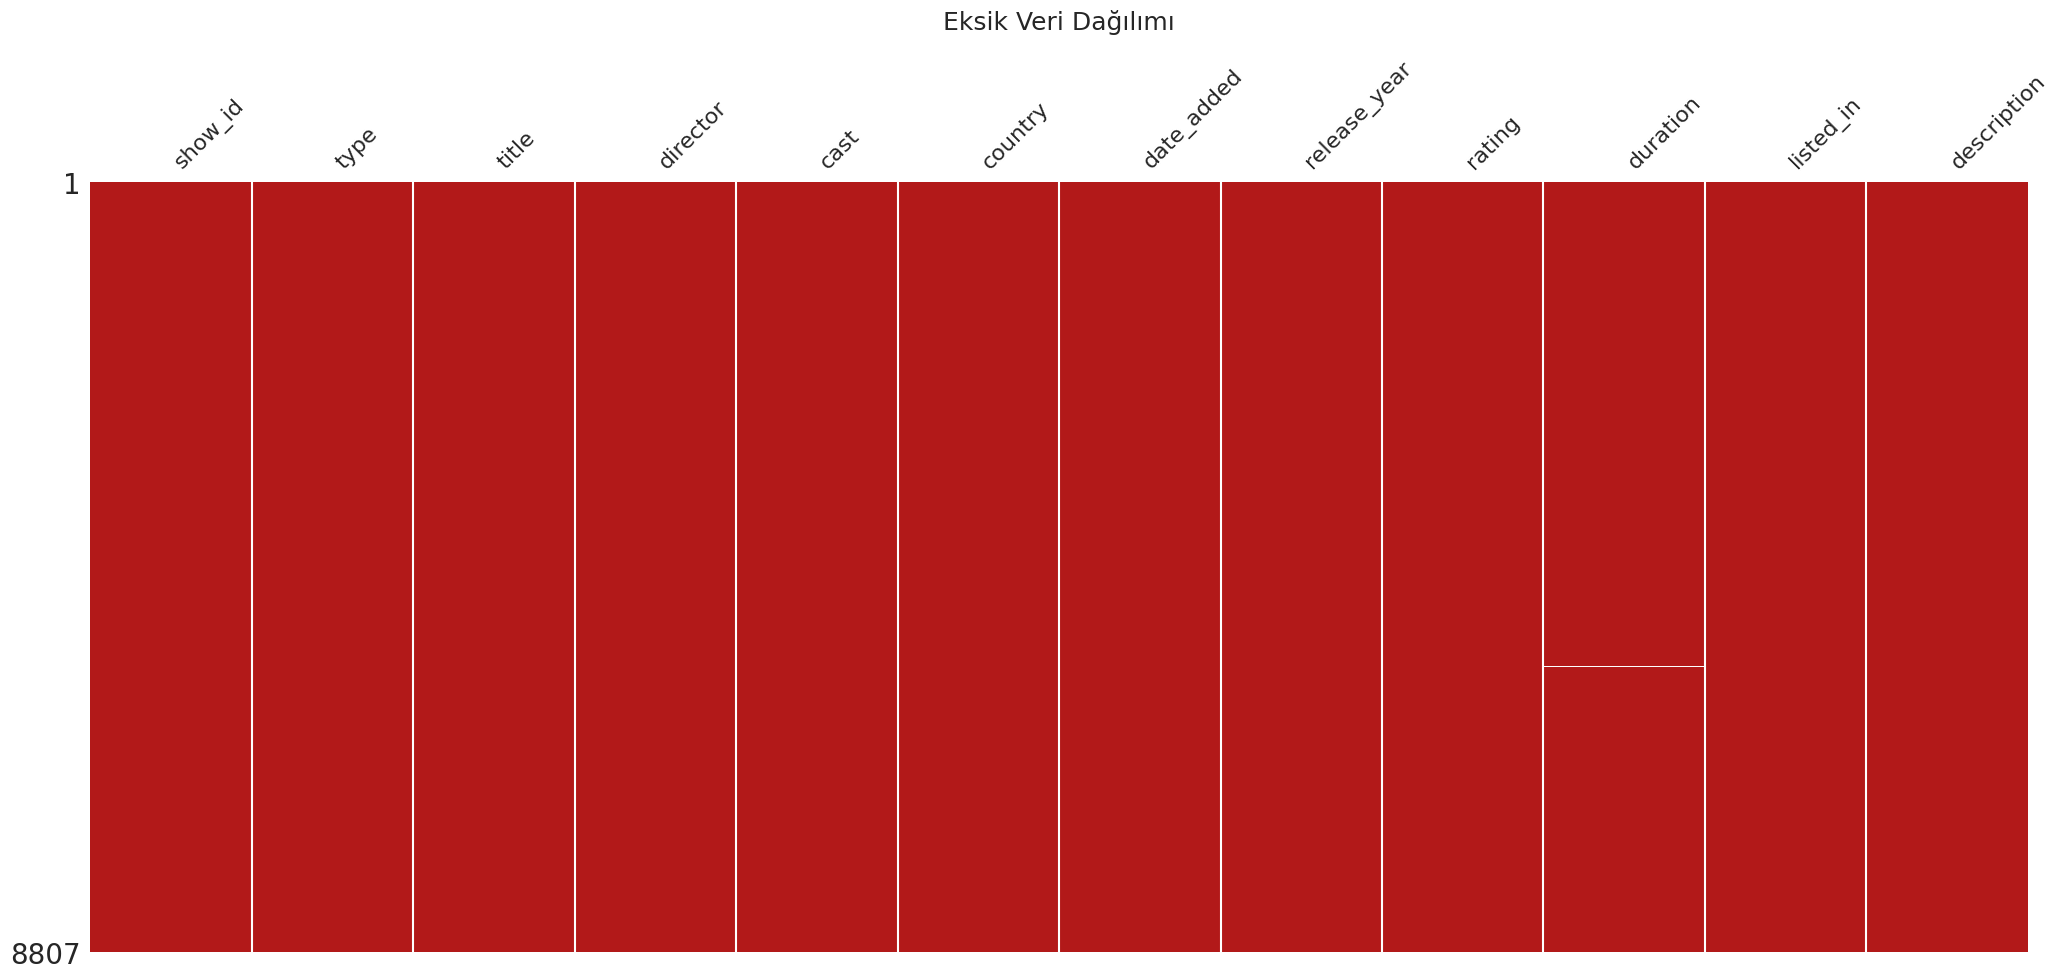

In [10]:
# 1. Eksik Veri Haritası (Matrix)
plt.figure(figsize=(12,6))
msno.matrix(df, color=(0.7, 0.1, 0.1), sparkline=False)
plt.title('Eksik Veri Dağılımı', fontsize=18, pad=20)
plt.show()

In [11]:
# 2. İçerik Türü Dağılımı (Pasta Grafiği + Halka Grafik)
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
types = df['type'].value_counts()

fig.add_trace(go.Pie(labels=types.index, values=types.values,
                     hole=.4, marker_colors=netflix_colors), 1, 1)
fig.add_trace(go.Pie(labels=types.index, values=types.values,
                     hole=.7, showlegend=False), 1, 2)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title_text='İçerik Tür Dağılımı', title_x=0.5)
fig.show()

In [12]:
# 3. Ülkelere Göre Dağılım (TreeMap)
country_counts = df.explode('country').groupby('country').size().reset_index(name='count')
top_countries = country_counts.sort_values('count', ascending=False).head(20)

fig = px.treemap(top_countries,
                 path=['country'],
                 values='count',
                 color='count',
                 color_continuous_scale='Reds',
                 title='Ülkelere Göre İçerik Dağılımı')
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()

In [13]:
# 4. Yıllara Göre İçerik Üretimi (Alan Grafiği)
yearly_content = df.groupby(['release_year', 'type']).size().unstack().fillna(0)
fig = px.area(yearly_content,
              x=yearly_content.index,
              y=yearly_content.columns,
              title='Yıllara Göre İçerik Üretimi',
              labels={'value':'İçerik Sayısı', 'release_year':'Yıl'},
              color_discrete_sequence=['#e50914', '#221f1f'])
fig.update_layout(hovermode='x unified')
fig.show()


<ipython-input-14-31e93d2a21e5>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




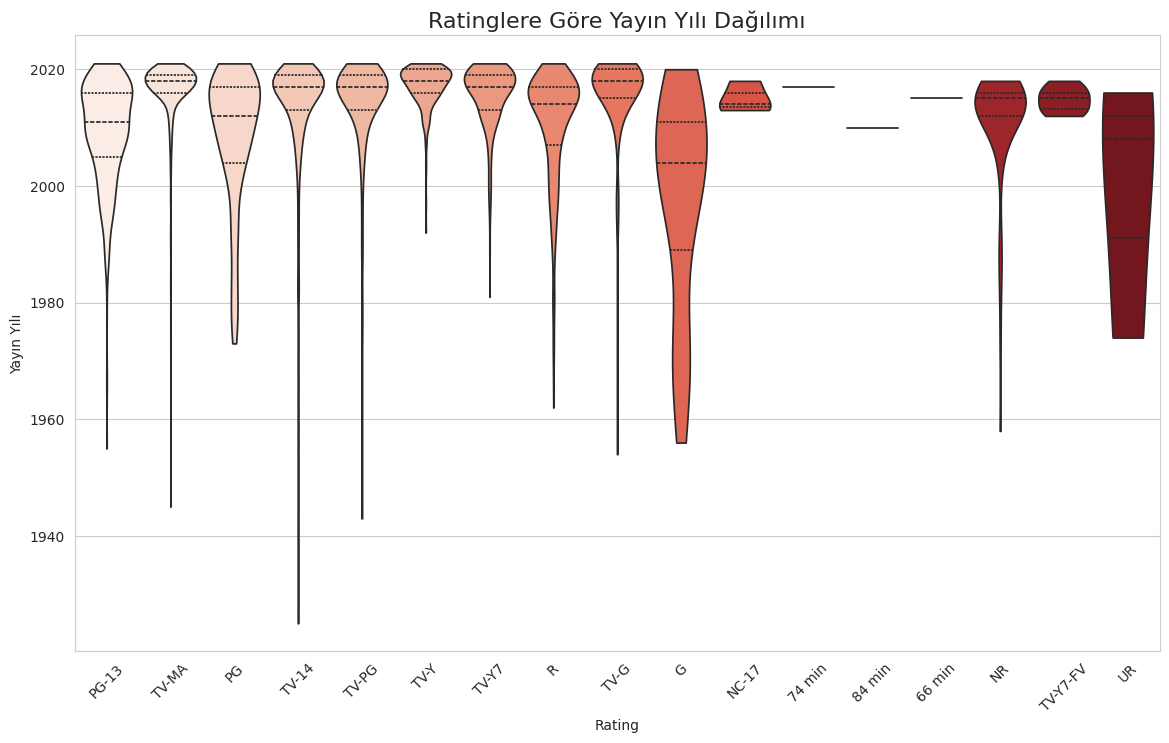

In [14]:
# 5. Rating Dağılımı (Violin Plot)
plt.figure(figsize=(14,8))
sns.violinplot(x='rating', y='release_year', data=df,
               inner='quartile', palette='Reds', cut=0)
plt.title('Ratinglere Göre Yayın Yılı Dağılımı', fontsize=16)
plt.xlabel('Rating')
plt.ylabel('Yayın Yılı')
plt.xticks(rotation=45)
plt.show()

In [15]:
# 6. Yönetmen-Aktör Network Grafı (En Üretken 25 Kişi)
directors = df['director'].str.split(', ').explode().value_counts().head(25)
actors = df['cast'].str.split(', ').explode().value_counts().head(25)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=directors.index,
    y=directors.values,
    mode='markers+text',
    name='Yönetmenler',
    marker=dict(size=directors.values/2, color='#e50914')
))

fig.add_trace(go.Scatter(
    x=actors.index,
    y=actors.values,
    mode='markers+text',
    name='Oyuncular',
    marker=dict(size=actors.values/2, color='#221f1f')
))

fig.update_layout(title='En Üretken 25 Yönetmen ve Oyuncu',
                 xaxis_title='İsimler',
                 yaxis_title='Katkıda Bulunduğu İçerik Sayısı',
                 template='plotly_white')
fig.show()

In [16]:
# 7. Türlerin Zaman İçinde Değişimi (Animasyonlu Grafik)
df['genre'] = df['listed_in'].str.split(', ')
genre_yearly = df.explode('genre').groupby(['release_year', 'genre']).size().reset_index(name='count')
top_genres = genre_yearly.groupby('genre')['count'].sum().nlargest(10).index

fig = px.bar(genre_yearly[genre_yearly['genre'].isin(top_genres)],
             x="genre",
             y="count",
             animation_frame="release_year",
             range_y=[0, 200],
             color='genre',
             color_discrete_sequence=px.colors.sequential.Reds)
fig.update_layout(title='Türlerin Yıllara Göre Değişimi',
                 xaxis_title='Tür',
                 yaxis_title='İçerik Sayısı')
fig.show()

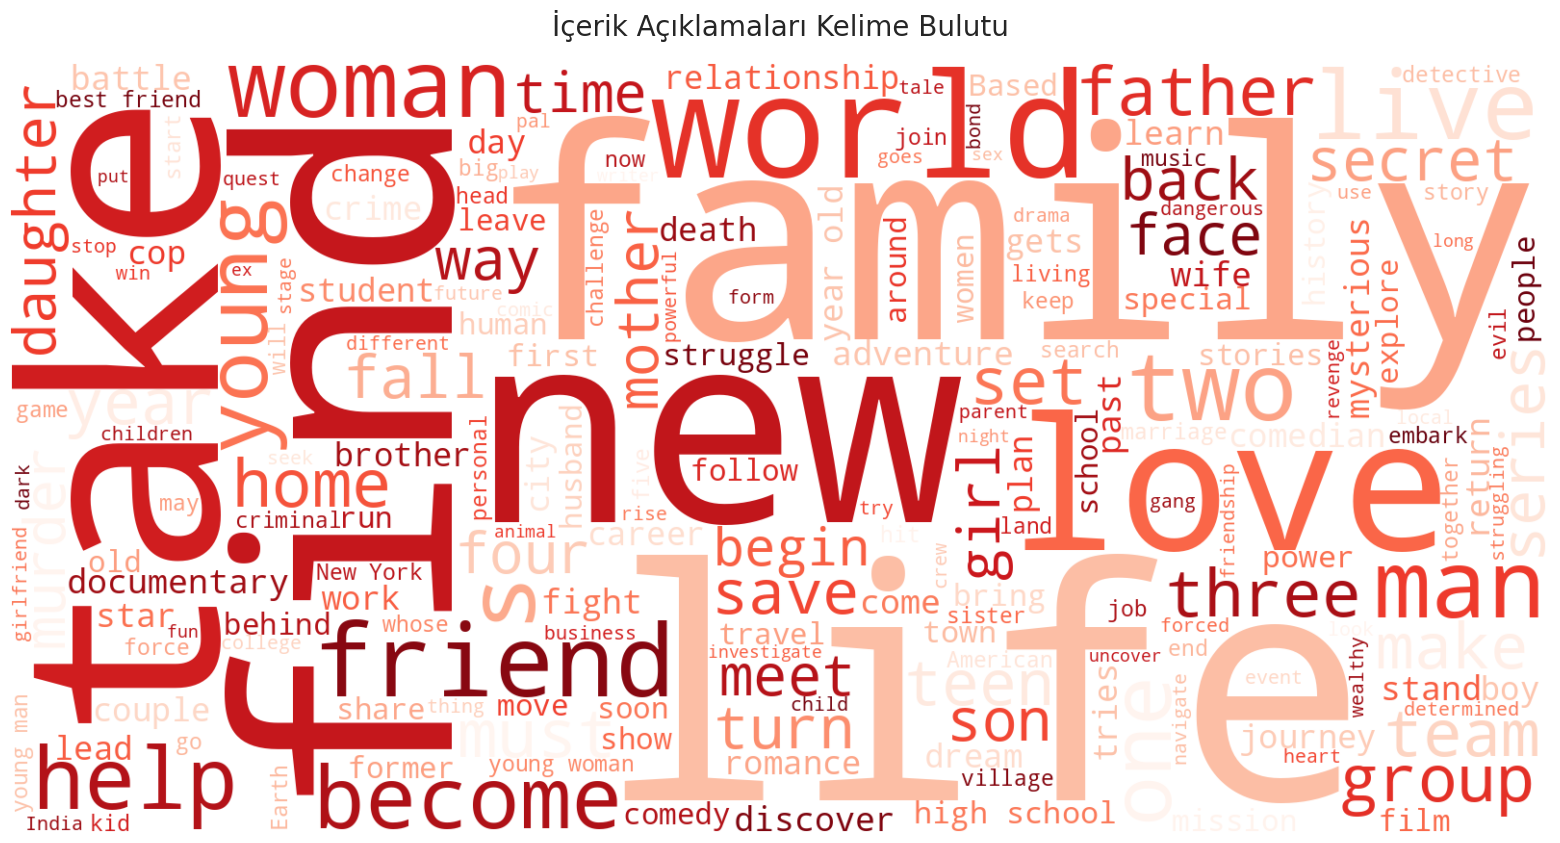

In [17]:
# 8. Metin Analizi (Word Cloud + Bigram Ağı)
text = ' '.join(df['description'].dropna())
wordcloud = WordCloud(width=1600, height=800,
                      background_color='white',
                      colormap='Reds').generate(text)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('İçerik Açıklamaları Kelime Bulutu', fontsize=20, pad=20)
plt.show()

In [18]:
# 9. Coğrafi Dağılım (Harita Görselleştirme)
country_geo = country_counts.rename(columns={'country':'name'})
fig = px.choropleth(country_geo,
                    locations="name",
                    locationmode='country names',
                    color="count",
                    hover_name="name",
                    color_continuous_scale='Reds',
                    title='Ülkelere Göre İçerik Dağılımı')
fig.show()


# İçerik Öneri Sistemi

In [19]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(df['description'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

def netflix_recommender(title, num_recommendations=5):
    try:
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:num_recommendations+1]
        movie_indices = [i[0] for i in sim_scores]
        return df[['title', 'type', 'listed_in', 'description']].iloc[movie_indices]
    except:
        return "Bu içerik bulunamadı veya yetersiz veri mevcut"

In [20]:
# Örnek Kullanım
netflix_recommender("Stranger Things")

,title,type,listed_in,description
4733,Rowdy Rathore,Movie,"Action & Adventure, Comedies, International Mo...",A con man uncovers a deadly secret and must sa...
8198,The Autopsy of Jane Doe,Movie,"Horror Movies, Independent Movies, Thrillers",A father-son team of small-town coroners perfo...
1240,Safe Haven,Movie,"Dramas, Romantic Movies",When a mysterious woman arrives in a small Nor...
2419,Big Stone Gap,Movie,"Comedies, Romantic Movies",A single middle-aged woman who has lived her w...
1487,Sakho & Mangane,TV Show,"Crime TV Shows, International TV Shows, TV Dramas",A by-the-book police captain and a brash young...
